In [70]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as signal

# Functions

In [2]:
# Steering Vector Function
def gen_steering_vectors(array_alignment, thetas):
    M = np.size(array_alignment, 0)  # Number of antenna elements    
    steering_vectors = np.zeros((M, np.size(thetas)), dtype=complex)
    for i in range(np.size(thetas)):    
        steering_vectors[:, i] = np.exp(array_alignment*1j*2*np.pi*np.cos(np.radians(thetas[i]))) # Scanning vector      
        
    return steering_vectors

In [3]:
# DoA Estimation Function
def DoA_MVDR(R,steering_vectors):
    R_inv  = np.linalg.inv(R) # invert the cross correlation matrix
    theta_index=0
    ADSINR = np.zeros(np.size(steering_vectors,1))
    for i in range(np.size(steering_vectors, 1)):             
        S_theta_ = steering_vectors[:, i]
        ADSINR[theta_index]=1*np.dot(np.conj(S_theta_),np.dot(R_inv,S_theta_))
        theta_index += 1
    
    ADSINR = np.reciprocal(ADSINR)
        
    return ADSINR

In [4]:
def MVDR_1D_Beamformer_Weights(theta,steering_vectors,R):
    R_inv  = np.linalg.inv(R) # invert the cross correlation matrix
    S_theta = steering_vectors[:, theta]
    weights = np.dot(R_inv,S_theta)/np.dot(np.conj(S_theta),np.dot(R_inv,S_theta))
    
    return weights

In [5]:
def MVDR_1D_Beamformer(rec_signal_1, rec_signal_2, weights_1, weights_2):
    updated_rec_signal_1 = np.dot(rec_signal_1.T,weights_1)
    print(np.shape(updated_rec_signal_1))
    updated_rec_signal_2 = np.dot(rec_signal_2.T,weights_2)
    updated_rec_signal_total = updated_rec_signal_1 + updated_rec_signal_2
    
    return updated_rec_signal_total

# Setting it Up

In [6]:
## Create Phased Array
d = 0.5 # Inter element spacing [lambda]
M = 2  # number of antenna elements in the antenna system (ULA)

In [7]:
# Calulate Steering Vector
array_alignment = np.arange(0, M, 1)* d
incident_angles= np.arange(0,181,1)
steering_vectors = gen_steering_vectors(array_alignment, incident_angles)

# Testing Synced Data

In [190]:
antenna_1 = np.fromfile("sync-stream1-2", dtype="float32")  # Loads data as float32 format
antenna_1 = antenna_1.astype(np.float32).view(np.complex64) # Converts to float64 complex
antenna_2 = np.fromfile("sync-stream2-2", dtype="float32")
antenna_2 = antenna_2.astype(np.float32).view(np.complex64)

In [191]:
start = 10000
end = 552101
end_of_file = 552101
rec_signal = np.vstack((antenna_1[start:end].T,antenna_2[start:end].T))
R = np.corrcoef(rec_signal)

In [192]:
DoA_spectrum = DoA_MVDR(R,steering_vectors)
DoA_Azimuth = np.argmax(DoA_spectrum)
print(DoA_Azimuth)

41


/projects/community/py-data-science-stack/5.1.0/kp807/envs/biopython/lib/python3.6/site-packages/ipykernel_launcher.py:8: ComplexWarning: Casting complex values to real discards the imaginary part
  


In [194]:
#plt.plot(DoA_spectrum)

In [197]:
weights = np.reshape(MVDR_1D_Beamformer_Weights(DoA_Azimuth,steering_vectors,R),[2,1])

# Testing Unsynced Data

In [200]:
antenna_1_non = np.fromfile("sync-stream1-2", dtype="float32")  # Loads data as float32 format
antenna_1_non = antenna_1_non.astype(np.float32).view(np.complex64) # Converts to float64 complex
antenna_2_non = np.fromfile("sync-stream2-2", dtype="float32")
antenna_2_non = antenna_2_non.astype(np.float32).view(np.complex64)

In [201]:
start = 10000
end = 400135
end_of_file = 400135
rec_signal_non = np.vstack((antenna_1_non[start:end].T,antenna_2_non[start:end].T))
np.shape(rec_signal_non)
R_non = np.corrcoef(rec_signal_non)

In [205]:
DoA_spectrum = DoA_MVDR(R_non,steering_vectors)
DoA_Azimuth = np.argmax(DoA_spectrum)
print(DoA_Azimuth)

45


/projects/community/py-data-science-stack/5.1.0/kp807/envs/biopython/lib/python3.6/site-packages/ipykernel_launcher.py:8: ComplexWarning: Casting complex values to real discards the imaginary part
  


In [207]:
#plt.plot(DoA_spectrum)

In [204]:
weights = np.reshape(MVDR_1D_Beamformer_Weights(DoA_Azimuth,steering_vectors,R_non),[2,1])

# Other Simulation

In [82]:
## Create Phased Array
d = 0.5 # Inter element spacing [lambda]
M = 2  # number of antenna elements in the antenna system (ULA)

#Test Signal Parameters
N = 2**12 # Samples used for test signal
azimuth = 60; # Incidence azimuth
elevation = 90; # Incidence elevation

# Array response vectors of the test signal broken into x,y subsets
x1 = np.exp(np.arange(0,M,1)*1j*2*np.pi*d*np.cos(np.deg2rad(azimuth)))
x2 = np.exp(np.arange(0,M,1)*1j*2*np.pi*d*np.cos(np.deg2rad(azimuth)))
y1 = np.exp(np.arange(0,M,1)*1j*2*np.pi*d*np.cos(np.deg2rad(elevation)))
y2 = np.exp(np.arange(0,M,1)*1j*2*np.pi*d*np.cos(np.deg2rad(elevation)))

In [3]:
# Generate multichannel test signal for x1
soi = np.random.normal(0,1,N)  # Signal of Interest
soi_matrix  = np.outer( soi, x1).T 

# Generate multichannel uncorrelated noise
noise = np.random.normal(0,np.sqrt(10**-1),(M,N))

# Create received signal array
rec_signal_x1 = soi_matrix + noise

# Generate multichannel test signal for x2
soi = np.random.normal(0,1,N)  # Signal of Interest
soi_matrix  = np.outer( soi, x2).T 

# Generate multichannel uncorrelated noise
noise = np.random.normal(0,np.sqrt(10**-1),(M,N))

# Create received signal array
rec_signal_x2 = soi_matrix + noise

# Generate multichannel test signal for y1
soi = np.random.normal(0,1,N)  # Signal of Interest
soi_matrix  = np.outer( soi, y1).T 

# Generate multichannel uncorrelated noise
noise = np.random.normal(0,np.sqrt(10**-1),(M,N))

# Create received signal array
rec_signal_y1 = soi_matrix + noise

# Generate multichannel test signal for y2
soi = np.random.normal(0,1,N)  # Signal of Interest
soi_matrix  = np.outer( soi, y2).T 

# Generate multichannel uncorrelated noise
noise = np.random.normal(0,np.sqrt(10**-1),(M,N))

# Create received signal array
rec_signal_y2 = soi_matrix + noise

In [4]:
# Calculate Correlation Coefficient
R_x1 = np.corrcoef(rec_signal_x1)
R_x2 = np.corrcoef(rec_signal_x2)
R_y1 = np.corrcoef(rec_signal_y1)
R_y2 = np.corrcoef(rec_signal_y2)

In [53]:
# Calulate Steering Vector
array_alignment = np.arange(0, M, 1)* d
incident_angles= np.arange(0,181,1)
steering_vectors = gen_steering_vectors(array_alignment, incident_angles)

In [54]:
np.shape(steering_vectors)

(2, 181)

In [69]:
DoA_Azimuth_1 = DoA_MVDR(R_x1,steering_vectors)

/projects/community/py-data-science-stack/5.1.0/kp807/envs/biopython/lib/python3.6/site-packages/ipykernel_launcher.py:8: ComplexWarning: Casting complex values to real discards the imaginary part
  


In [68]:
DoA_Azimuth_1 = DoA_MVDR(R_x1,steering_vectors)
DoA_Azimuth_2 = DoA_MVDR(R_x2,steering_vectors)
DoA_Elevation_1 = DoA_MVDR(R_y1,steering_vectors)
DoA_Elevation_2 = DoA_MVDR(R_y2,steering_vectors)

/projects/community/py-data-science-stack/5.1.0/kp807/envs/biopython/lib/python3.6/site-packages/ipykernel_launcher.py:8: ComplexWarning: Casting complex values to real discards the imaginary part
  


NameError: name 'R_x2' is not defined

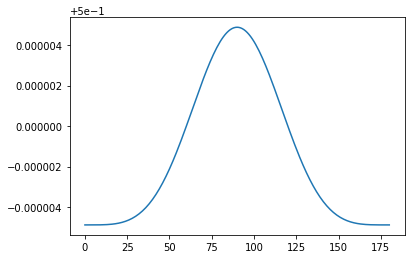

In [70]:
plt.plot(DoA_Azimuth_1)

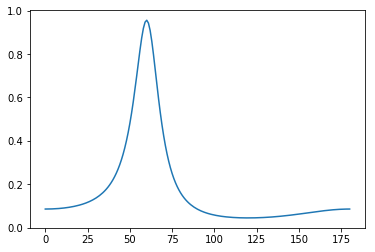

In [10]:
plt.plot(DoA_Azimuth_2)

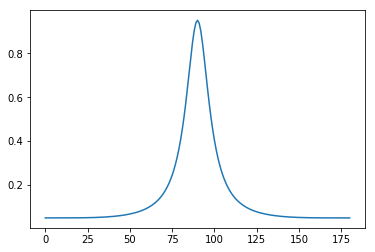

In [11]:
plt.plot(DoA_Elevation_1)

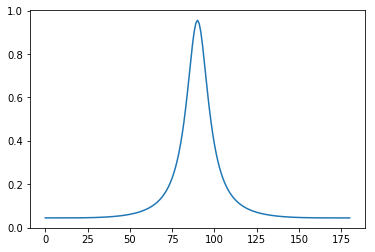

In [12]:
plt.plot(DoA_Elevation_2)

In [13]:
DoA_Azimuth_Array = 0.5*(DoA_Azimuth_1 + DoA_Azimuth_2)
DoA_Elevation_Array = 0.5*(DoA_Elevation_1 + DoA_Elevation_2)

In [14]:
DoA_Azimuth = np.argmax(DoA_Azimuth_Array)
DoA_Elevation = np.argmax(DoA_Elevation_Array)

In [15]:
print(DoA_Azimuth)
print(DoA_Elevation)

60
90


In [17]:
weights_x1 = np.reshape(MVDR_1D_Beamformer_Weights(DoA_Azimuth,steering_vectors,R_x1),[2,1])
weights_x2 = np.reshape(MVDR_1D_Beamformer_Weights(DoA_Azimuth,steering_vectors,R_x2),[2,1])
weights_y1 = np.reshape(MVDR_1D_Beamformer_Weights(DoA_Elevation,steering_vectors,R_y1),[2,1])
weights_y2 = np.reshape(MVDR_1D_Beamformer_Weights(DoA_Elevation,steering_vectors,R_y2),[2,1])

In [18]:
print(weights_x1)
print(weights_x2)
print(weights_y1)
print(weights_y2)

[[0.5       +0.01193898j]
 [0.01193898+0.5j       ]]
[[0.5       +0.02355441j]
 [0.02355441+0.5j       ]]
[[0.5-1.08241272e-18j]
 [0.5+9.72659474e-17j]]
[[0.5+2.08193681e-18j]
 [0.5+9.41015979e-17j]]


In [20]:
final_updated_signal_xdirection = MVDR_1D_Beamformer(rec_signal_x1,rec_signal_x2,weights_x1,weights_x2)
final_updated_signal_ydirection = MVDR_1D_Beamformer(rec_signal_y1,rec_signal_y2,weights_y1,weights_y2)

(4096, 1)
(4096, 1)


/projects/community/py-data-science-stack/5.1.0/kp807/envs/biopython/lib/python3.6/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


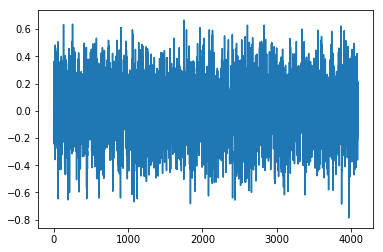

In [21]:
plt.plot(final_updated_signal_xdirection)

/projects/community/py-data-science-stack/5.1.0/kp807/envs/biopython/lib/python3.6/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


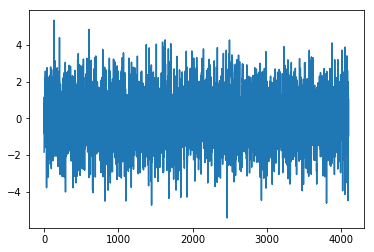

In [22]:
plt.plot(final_updated_signal_ydirection)

In [24]:
    M_x = np.size(array_alignment_x, 0)  # Number of antenna elements in x
    M_y = np.size(array_alignment_y,0) # Number of antenna elements in y
    steering_vectors = np.zeros((M_x, M_y,  np.size(thetas), np.size(phis)), dtype=complex)
    for i in range(np.size(thetas)): 
        for j in range(np.size(phis))
            steering_vectors[:,:,i, j] = np.exp(array_alignment*1j*2*np.pi*np.cos(np.radians(thetas[i]))) # Scanning vector 

SyntaxError: invalid syntax (<ipython-input-24-e227c774aa11>, line 5)